Streaming output truncated to the last 5000 lines.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive class for AUC.
Using class 'FAKE' (index 0) as the positive clas

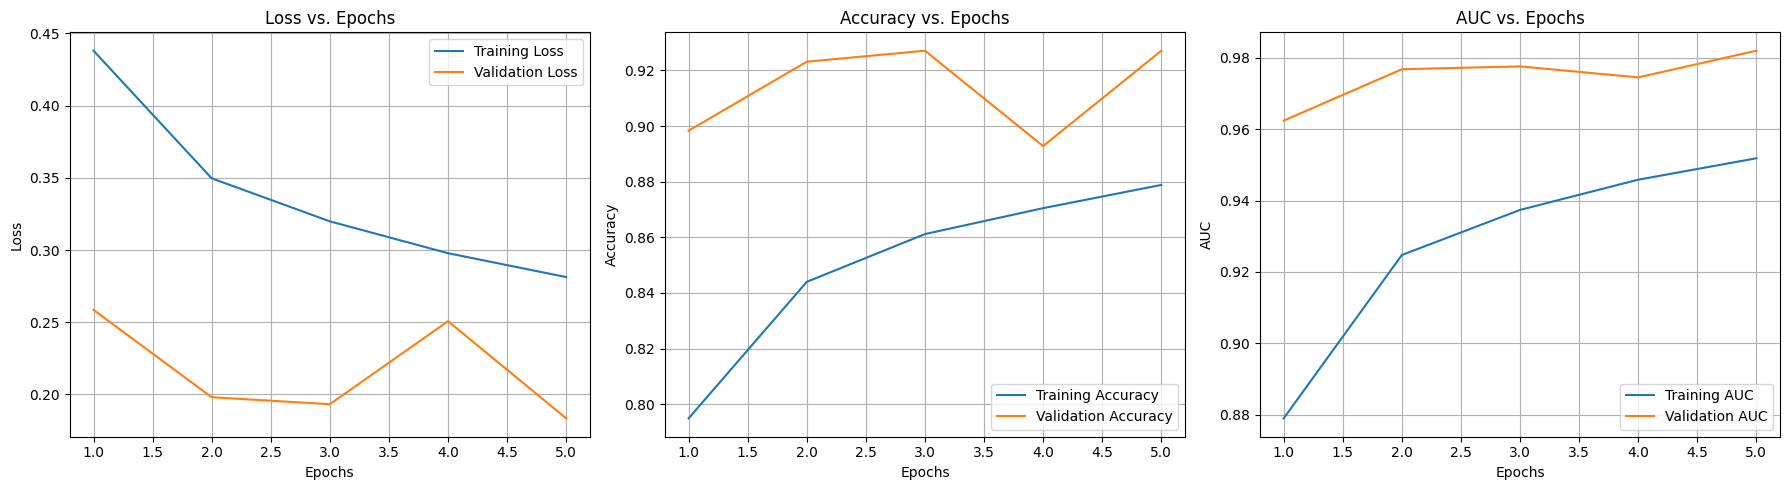

In [ ]:
import os
import shutil
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub # Import kagglehub

# --- 0. Configuration Parameters ---
KAGGLE_DATASET_SLUG = 'birdy654/cifake-real-and-ai-generated-synthetic-images' # Kaggle Hub slug
# DATA_DIR will be determined by kagglehub
MODEL_NAME = 'resnet50'
NUM_CLASSES = 2  # REAL vs FAKE
BATCH_SIZE = 32 # Adjust based on GPU memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Download Dataset using kagglehub ---
print(f"Downloading dataset {KAGGLE_DATASET_SLUG} using kagglehub...")
try:
    # Download latest version and get the path to the downloaded files
    dataset_root_path = kagglehub.dataset_download(KAGGLE_DATASET_SLUG)
    print(f"Dataset downloaded to: {dataset_root_path}")
except Exception as e:
    print(f"Error downloading dataset via kagglehub: {e}")
    print("Please ensure you have kagglehub installed (pip install kagglehub) and are authenticated.")
    exit()

# Determine the actual path to the 'train' directory
# The CIFake dataset, when unzipped, typically has 'train' and 'test' folders directly inside.
train_data_path = os.path.join(dataset_root_path, 'train')
# test_data_path_original = os.path.join(dataset_root_path, 'test') # Original test set, unused as we split

if not os.path.exists(train_data_path):
    print(f"Error: Training data path {train_data_path} does not exist after download.")
    # Let's list the contents of dataset_root_path to help debug if 'train' is not found
    print(f"Contents of {dataset_root_path}: {os.listdir(dataset_root_path)}")
    # Common issue: data might be in a subfolder named after the dataset.
    # e.g., .../cifake-real-and-ai-generated-synthetic-images/train/
    # This is less common with kagglehub's direct path but good to be aware of.
    # For this specific dataset, 'train' should be directly in dataset_root_path.
    exit()
else:
    print(f"Found training data at: {train_data_path}")


# --- 2. Data Preprocessing and Loading ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Augmentation: random crop
        transforms.RandomHorizontalFlip(),  # Augmentation: random flip
        transforms.ToTensor(),              # Convert PIL image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Same as validation transforms
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the entire original training set to get all samples and targets for splitting
full_train_dataset_info = datasets.ImageFolder(train_data_path)
class_names = full_train_dataset_info.classes
print(f"Classes: {class_names}")
# It's important that 'FAKE' and 'REAL' are correctly indexed for AUC calculation later.
# Typically, ImageFolder sorts them alphabetically: FAKE (0), REAL (1).
# We will assume 'FAKE' is the positive class for AUC.
POSITIVE_CLASS_NAME_FOR_AUC = 'FAKE'
if POSITIVE_CLASS_NAME_FOR_AUC not in class_names:
    print(f"Error: Positive class '{POSITIVE_CLASS_NAME_FOR_AUC}' for AUC not found in dataset classes: {class_names}")
    # Fallback or choose another class
    if class_names:
        POSITIVE_CLASS_NAME_FOR_AUC = class_names[0]
        print(f"Warning: Using '{POSITIVE_CLASS_NAME_FOR_AUC}' as positive class for AUC instead.")
    else:
        print("Error: No classes found in dataset.")
        exit()


print(f"Total images in original training set: {len(full_train_dataset_info)}")

# Split dataset indices (60% train, 20% val, 20% test)
total_len = len(full_train_dataset_info)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len # Ensure all data is used

print(f"Splitting data: Train={train_len}, Validation={val_len}, Test={test_len}")

# Get all targets for stratified splitting
targets = [s[1] for s in full_train_dataset_info.samples]
indices = list(range(total_len))

# First split: train vs (validation + test)
train_indices, remaining_indices, _, _ = train_test_split( # Don't need train_targets, remaining_targets here
    indices, targets, test_size=(val_len + test_len) / total_len, random_state=42, stratify=targets
)

# Need remaining_targets for the second stratified split
remaining_targets_for_split = [targets[i] for i in remaining_indices]
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, remaining_targets_for_split, test_size=test_len / (val_len + test_len), random_state=42, stratify=remaining_targets_for_split
)

# Helper class to apply specific transforms to Subsets made from original file paths
class SubsetWithCustomTransform(torch.utils.data.Dataset):
    def __init__(self, base_dataset_filepaths_labels, transform=None):
        self.filepaths_labels = base_dataset_filepaths_labels # List of (filepath, label)
        self.transform = transform
        self.loader = datasets.folder.default_loader # PIL loader

    def __getitem__(self, index):
        filepath, label = self.filepaths_labels[index]
        img = self.loader(filepath) # Load PIL image
        if self.transform:
            img = self.transform(img) # Apply transform
        return img, label

    def __len__(self):
        return len(self.filepaths_labels)

# Get original file paths and labels to create new datasets with specific transforms
original_samples = full_train_dataset_info.samples

train_samples_list = [original_samples[i] for i in train_indices]
val_samples_list = [original_samples[i] for i in val_indices]
test_samples_list = [original_samples[i] for i in test_indices]

image_datasets = {
    'train': SubsetWithCustomTransform(train_samples_list, data_transforms['train']),
    'val': SubsetWithCustomTransform(val_samples_list, data_transforms['val']),
    'test': SubsetWithCustomTransform(test_samples_list, data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2) # Shuffle only training data
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")


# --- 3. Build ResNet-50 Model ---
def get_model(model_name_str, num_classes_val, pretrained=True): # Renamed args to avoid conflict
    if model_name_str == 'resnet50':
        if pretrained:
            weights = models.ResNet50_Weights.IMAGENET1K_V1 # Use recommended weights enum
            model_ft = models.resnet50(weights=weights)
        else:
            model_ft = models.resnet50(weights=None) # No pretrained weights

        num_ftrs = model_ft.fc.in_features # Get number of input features for the FC layer
        model_ft.fc = nn.Linear(num_ftrs, num_classes_val) # Replace FC layer for our number of classes
    else:
        raise ValueError("Model not supported")
    return model_ft

model = get_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(DEVICE) # Move model to GPU if available

criterion = nn.CrossEntropyLoss() # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer
# Optional: Learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 4. Training and Evaluation Functions ---
def train_model_epoch(current_model, dataloader, current_criterion, current_optimizer, device): # Renamed args
    current_model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        current_optimizer.zero_grad() # Zero the parameter gradients

        with torch.set_grad_enabled(True): # Enable gradient computation
            outputs = current_model(inputs) # Forward pass
            _, preds_classes = torch.max(outputs, 1) # Get predicted classes
            loss = current_criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            current_optimizer.step() # Optimize

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds_classes == labels.data)

        # For AUC: collect true labels and predicted probabilities for the positive class
        all_labels_list.extend(labels.cpu().numpy())
        positive_class_idx = class_names.index(POSITIVE_CLASS_NAME_FOR_AUC)
        label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}
        print(f"Using class '{POSITIVE_CLASS_NAME_FOR_AUC}' (index {positive_class_idx}) as the positive class for AUC.")
        probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().detach().numpy()
        all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    # Handle cases where a batch might have only one class, leading to invalid AUC
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)


    return epoch_loss, epoch_acc.item(), epoch_auc

def evaluate_model(current_model, dataloader, current_criterion, device, phase='val'): # Renamed args
    current_model.eval() # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    with torch.no_grad(): # Disable gradient computation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = current_model(inputs)
            _, preds_classes = torch.max(outputs, 1)
            loss = current_criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_classes == labels.data)

            all_labels_list.extend(labels.cpu().numpy())
            positive_class_idx = class_names.index(POSITIVE_CLASS_NAME_FOR_AUC)
            label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}
            #print(f"Using class '{POSITIVE_CLASS_NAME_FOR_AUC}' (index {positive_class_idx}) as the positive class for AUC.")
            probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().numpy()
            all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)


    return epoch_loss, epoch_acc.item(), epoch_auc

# --- 5. Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

print("\nStarting Training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    # Train phase
    train_loss, train_acc, train_auc = train_model_epoch(model, dataloaders['train'], criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f}")

    # Validation phase
    val_loss, val_acc, val_auc = evaluate_model(model, dataloaders['val'], criterion, DEVICE, phase='val')
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

    # if scheduler:
    #     scheduler.step() # Step the LR scheduler if used

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time // 60:.0f}m {training_time % 60:.0f}s")

# --- 6. Evaluate on Test Set ---
print("\nEvaluating on Test Set...")
test_loss, test_acc, test_auc = evaluate_model(model, dataloaders['test'], criterion, DEVICE, phase='test')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- 7. Plot Results ---
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(18, 5)) # Create a figure for the plots

plt.subplot(1, 3, 1) # First subplot for Loss
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2) # Second subplot for Accuracy
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3) # Third subplot for AUC
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title('AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot params for a tight layout
plt.savefig("training_metrics_plot.png") # Save the plot
print("\nPlot saved as training_metrics_plot.png")
plt.show() # Display the plot

# (Optional) Save the trained model
# model_save_path = f'{MODEL_NAME}_cifake_epochs{NUM_EPOCHS}_kagglehub.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to training_history.csv")

Training history saved to training_history.csv


In [1]:
import pandas as pd
history_df = pd.read_csv("training_history_resnet50.csv")


Plot saved as training_metrics_ResNet50_plot.png


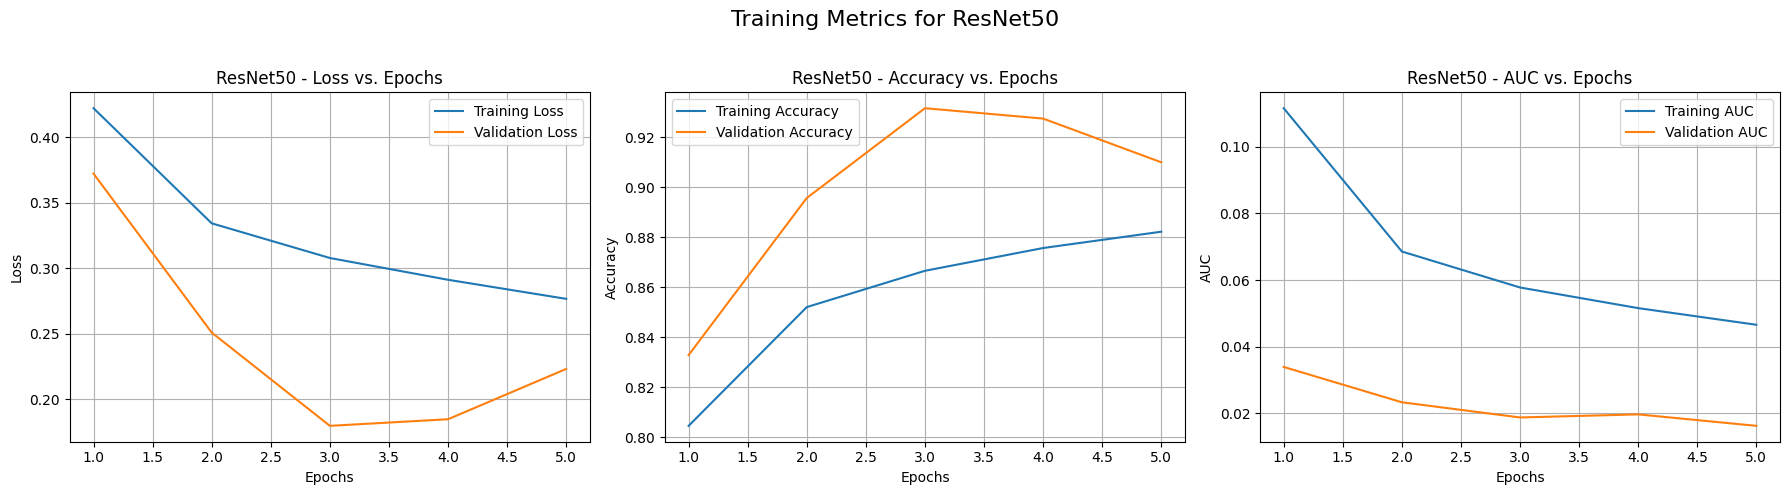

In [5]:
NUM_EPOCHS = 5
MODEL_NAME = "ResNet50"

import matplotlib.pyplot as plt
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 5))
history = history_df

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} - Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title(f'{MODEL_NAME} - Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title(f'{MODEL_NAME} - AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(f"training_metrics_{MODEL_NAME}_plot.png")
print(f"\nPlot saved as training_metrics_{MODEL_NAME}_plot.png")
plt.show()

Using device: cuda
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']
Using 'FAKE' as the positive class for AUC calculation.
Total images in original training set: 100000
Splitting data: Train=60000, Validation=20000, Test=20000
Train dataset size: 60000
Validation dataset size: 20000
Test dataset size: 20000

Starting Training for Inception V3...
Epoch 1/5
----------
Train Loss: 0.5351 Acc: 0.8296 AUC: 0.9105
Val Loss: 0.2184 Acc: 0.9118 AUC: 0.9709
Epoch 2/5
----------
Train Loss: 0.4380 Acc: 0.8658 AUC: 0.9404
Val Loss: 0.1803 Acc: 0.9334 AUC: 0.9810
Epoch 3/5
----------
Train Loss: 0.4059 Acc: 0.8774 AUC: 0.9488
Val Loss: 0.1760 Acc: 0.9308 AUC: 0.9828
Epoch 4/5
----------
Train Loss: 0.3830 Acc: 0.8865 AUC: 0.9544
Val Loss: 0.1625 Acc: 0.9395 AUC: 0.9843
Epoch 5/5
----------
Train Loss: 0.3613 Acc: 0.8917 AUC: 0.9593
Val Loss: 0.1866 Acc: 0.9238 AUC: 0.9857

Training complete in 76m 37s

Evaluating Inception V3 on Test Set

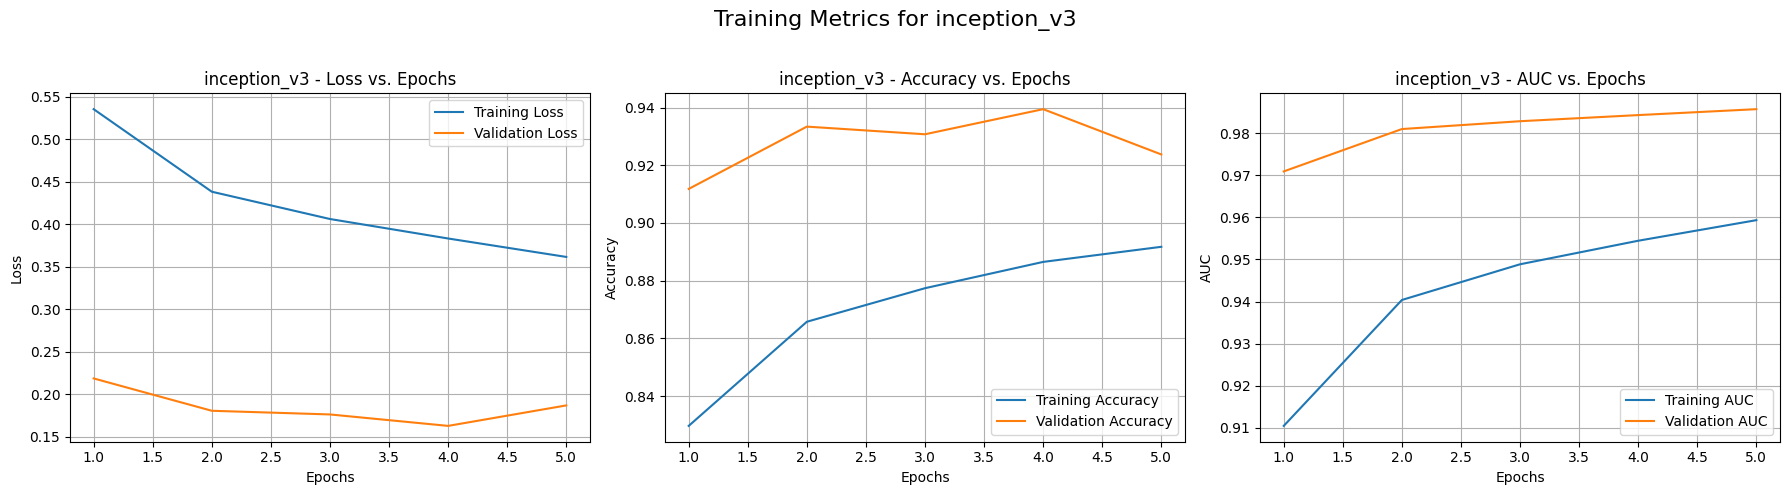

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub # Import kagglehub

# --- 0. Configuration Parameters ---
KAGGLE_DATASET_SLUG = 'birdy654/cifake-real-and-ai-generated-synthetic-images' # Kaggle Hub slug
MODEL_NAME = 'inception_v3' # Changed to Inception V3
NUM_CLASSES = 2  # REAL vs FAKE
BATCH_SIZE = 32 # Adjust based on GPU memory (InceptionV3 might need more)
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Download Dataset using kagglehub ---
print(f"Downloading dataset {KAGGLE_DATASET_SLUG} using kagglehub...")
try:
    dataset_root_path = kagglehub.dataset_download(KAGGLE_DATASET_SLUG)
    print(f"Dataset downloaded to: {dataset_root_path}")
except Exception as e:
    print(f"Error downloading dataset via kagglehub: {e}")
    print("Please ensure you have kagglehub installed (pip install kagglehub) and Kaggle API configured.")
    exit()

train_data_path = os.path.join(dataset_root_path, 'train')

if not os.path.exists(train_data_path):
    print(f"Error: Training data path {train_data_path} does not exist after download.")
    print(f"Please check the structure of the downloaded dataset at {dataset_root_path}")
    exit()

# --- 2. Data Preprocessing and Loading ---
# Inception V3 expects 299x299 input images
INPUT_SIZE = 299
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE + 43), # Resize to slightly larger than input size (e.g., 299/0.875 ~ 342)
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Same as validation transforms
        transforms.Resize(INPUT_SIZE + 43),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_train_dataset_info = datasets.ImageFolder(train_data_path)
class_names = full_train_dataset_info.classes
print(f"Classes: {class_names}")
POSITIVE_CLASS_FOR_AUC = 'FAKE' # Define which class is "positive" for AUC
if POSITIVE_CLASS_FOR_AUC not in class_names:
    print(f"Error: Positive class '{POSITIVE_CLASS_FOR_AUC}' for AUC not found in dataset classes: {class_names}")
    # Fallback or choose another class if necessary, here we exit.
    exit()
print(f"Using '{POSITIVE_CLASS_FOR_AUC}' as the positive class for AUC calculation.")
print(f"Total images in original training set: {len(full_train_dataset_info)}")

total_len = len(full_train_dataset_info)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

print(f"Splitting data: Train={train_len}, Validation={val_len}, Test={test_len}")

targets = [s[1] for s in full_train_dataset_info.samples]
indices = list(range(total_len))

train_indices, remaining_indices, _, _ = train_test_split(
    indices, targets, test_size=(val_len + test_len) / total_len, random_state=42, stratify=targets
)
remaining_targets = [targets[i] for i in remaining_indices]
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, remaining_targets, test_size=test_len / (val_len + test_len), random_state=42, stratify=remaining_targets
)

class SubsetWithCustomTransform(torch.utils.data.Dataset):
    def __init__(self, base_dataset_filepaths_labels, transform=None):
        self.filepaths_labels = base_dataset_filepaths_labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __getitem__(self, index):
        filepath, label = self.filepaths_labels[index]
        img = self.loader(filepath)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.filepaths_labels)

original_samples = full_train_dataset_info.samples
train_samples_list = [original_samples[i] for i in train_indices]
val_samples_list = [original_samples[i] for i in val_indices]
test_samples_list = [original_samples[i] for i in test_indices]

image_datasets = {
    'train': SubsetWithCustomTransform(train_samples_list, data_transforms['train']),
    'val': SubsetWithCustomTransform(val_samples_list, data_transforms['val']),
    'test': SubsetWithCustomTransform(test_samples_list, data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")

# --- 3. Build Inception V3 Model ---
def get_model(model_name_str, num_classes_val, pretrained=True):
    model_ft = None
    if model_name_str == 'inception_v3':
        if pretrained:
            weights = models.Inception_V3_Weights.IMAGENET1K_V1
            model_ft = models.inception_v3(weights=weights)
        else:
            model_ft = models.inception_v3(weights=None, aux_logits=True) # Ensure aux_logits for consistency if not pretrained

        # Handle the main output layer
        num_ftrs_main = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs_main, num_classes_val)

        # Handle the auxiliary output layer if it exists (it does by default for pretrained Inception V3)
        # For pretrained models, aux_logits is True by default.
        if hasattr(model_ft, 'AuxLogits') and model_ft.AuxLogits is not None:
            num_ftrs_aux = model_ft.AuxLogits.fc.in_features
            model_ft.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes_val)
    else:
        raise ValueError(f"Model {model_name_str} not supported by this function")
    return model_ft

model = get_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Training and Evaluation Functions ---
def train_model_epoch(current_model, dataloader, loss_criterion, opt, current_device):
    current_model.train() # Set model to training mode (enables aux logits for Inception V3)
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    for inputs, labels in dataloader:
        inputs = inputs.to(current_device)
        labels = labels.to(current_device)

        opt.zero_grad()

        with torch.set_grad_enabled(True):
            # Inception V3 with aux_logits=True returns InceptionOutputs(outputs, aux_outputs) during train()
            outputs_tuple = current_model(inputs)
            if isinstance(outputs_tuple, tuple): # Check if it's InceptionOutputs
                main_outputs, aux_outputs = outputs_tuple
                loss1 = loss_criterion(main_outputs, labels)
                loss2 = loss_criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2 # As per Inception V3 paper
            else: # Fallback if aux_logits are off or model behaves differently
                main_outputs = outputs_tuple
                loss = loss_criterion(main_outputs, labels)

            _, preds_classes = torch.max(main_outputs, 1) # Predictions from main output
            loss.backward()
            opt.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds_classes == labels.data)

        all_labels_list.extend(labels.cpu().numpy())
        positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
        label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}
        #print(f"Using class '{POSITIVE_CLASS_NAME_FOR_AUC}' (index {positive_class_idx}) as the positive class for AUC.")
        probs = torch.softmax(main_outputs, dim=1)[:, positive_class_idx].cpu().detach().numpy()
        all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

def evaluate_model(current_model, dataloader, loss_criterion, current_device, phase='val'):
    current_model.eval() # Set model to evaluation mode (disables aux logits for Inception V3)
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []
    positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
    label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}


    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(current_device)
            labels = labels.to(current_device)

            # Inception V3 returns only main_outputs during eval()
            main_outputs = current_model(inputs)
            loss = loss_criterion(main_outputs, labels)
            _, preds_classes = torch.max(main_outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_classes == labels.data)

            all_labels_list.extend(labels.cpu().numpy())
            positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
            probs = torch.softmax(main_outputs, dim=1)[:, positive_class_idx].cpu().numpy()
            all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

# --- 5. Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

print("\nStarting Training for Inception V3...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    train_loss, train_acc, train_auc = train_model_epoch(model, dataloaders['train'], criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f}")

    val_loss, val_acc, val_auc = evaluate_model(model, dataloaders['val'], criterion, DEVICE, phase='val')
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time // 60:.0f}m {training_time % 60:.0f}s")

# --- 6. Evaluate on Test Set ---
print("\nEvaluating Inception V3 on Test Set...")
test_loss, test_acc, test_auc = evaluate_model(model, dataloaders['test'], criterion, DEVICE, phase='test')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- 7. Plot Results ---
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} - Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title(f'{MODEL_NAME} - Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title(f'{MODEL_NAME} - AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(f"training_metrics_{MODEL_NAME}_plot.png")
print(f"\nPlot saved as training_metrics_{MODEL_NAME}_plot.png")
plt.show()

# (Optional) Save the trained model
# model_save_path = f'{MODEL_NAME}_cifake_epochs{NUM_EPOCHS}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_inception.csv', index=False)
print("Training history saved to training_history_inception.csv")

Training history saved to training_history_inception.csv


Using device: cuda
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']
Using 'FAKE' as the positive class for AUC calculation.
Total images in original training set: 100000
Splitting data: Train=60000, Validation=20000, Test=20000
Train dataset size: 60000
Validation dataset size: 20000
Test dataset size: 20000

Starting Training for efficientnet_b0...
Epoch 1/5
----------
Train Loss: 0.3069 Acc: 0.8687 AUC: 0.9427
Val Loss: 0.1556 Acc: 0.9387 AUC: 0.9865
Epoch 2/5
----------
Train Loss: 0.2544 Acc: 0.8931 AUC: 0.9607
Val Loss: 0.1574 Acc: 0.9388 AUC: 0.9849
Epoch 3/5
----------
Train Loss: 0.2344 Acc: 0.9025 AUC: 0.9667
Val Loss: 0.1242 Acc: 0.9530 AUC: 0.9907
Epoch 4/5
----------
Train Loss: 0.2206 Acc: 0.9092 AUC: 0.9704
Val Loss: 0.1135 Acc: 0.9565 AUC: 0.9929
Epoch 5/5
----------
Train Loss: 0.2070 Acc: 0.9158 AUC: 0.9739
Val Loss: 0.1061 Acc: 0.9612 AUC: 0.9932

Training complete in 27m 23s

Evaluating efficientnet_b0 on Te

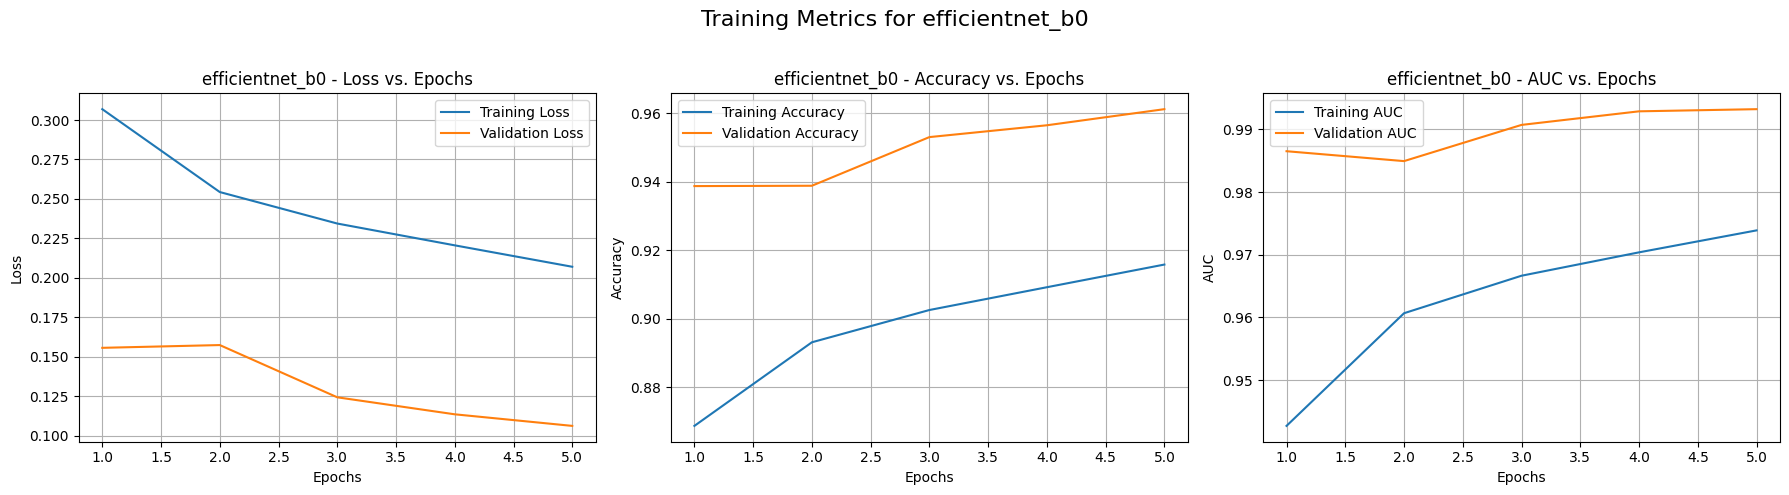

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub # Import kagglehub

# --- 0. Configuration Parameters ---
KAGGLE_DATASET_SLUG = 'birdy654/cifake-real-and-ai-generated-synthetic-images' # Kaggle Hub slug
MODEL_NAME = 'efficientnet_b0' # Changed to EfficientNet-B0
NUM_CLASSES = 2  # REAL vs FAKE
BATCH_SIZE = 32 # Adjust based on GPU memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Download Dataset using kagglehub ---
print(f"Downloading dataset {KAGGLE_DATASET_SLUG} using kagglehub...")
try:
    dataset_root_path = kagglehub.dataset_download(KAGGLE_DATASET_SLUG)
    print(f"Dataset downloaded to: {dataset_root_path}")
except Exception as e:
    print(f"Error downloading dataset via kagglehub: {e}")
    print("Please ensure you have kagglehub installed (pip install kagglehub) and Kaggle API configured.")
    exit()

train_data_path = os.path.join(dataset_root_path, 'train')

if not os.path.exists(train_data_path):
    print(f"Error: Training data path {train_data_path} does not exist after download.")
    print(f"Please check the structure of the downloaded dataset at {dataset_root_path}")
    exit()

# --- 2. Data Preprocessing and Loading ---
# EfficientNet-B0 expects 224x224 input images
INPUT_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Standard for 224 input (e.g., 224 / 0.875)
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Same as validation transforms
        transforms.Resize(256),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_train_dataset_info = datasets.ImageFolder(train_data_path)
class_names = full_train_dataset_info.classes
print(f"Classes: {class_names}")
POSITIVE_CLASS_FOR_AUC = 'FAKE' # Define which class is "positive" for AUC
if POSITIVE_CLASS_FOR_AUC not in class_names:
    print(f"Error: Positive class '{POSITIVE_CLASS_FOR_AUC}' for AUC not found in dataset classes: {class_names}")
    exit()
print(f"Using '{POSITIVE_CLASS_FOR_AUC}' as the positive class for AUC calculation.")
print(f"Total images in original training set: {len(full_train_dataset_info)}")

total_len = len(full_train_dataset_info)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

print(f"Splitting data: Train={train_len}, Validation={val_len}, Test={test_len}")

targets = [s[1] for s in full_train_dataset_info.samples]
indices = list(range(total_len))

train_indices, remaining_indices, _, _ = train_test_split(
    indices, targets, test_size=(val_len + test_len) / total_len, random_state=42, stratify=targets
)
remaining_targets = [targets[i] for i in remaining_indices]
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, remaining_targets, test_size=test_len / (val_len + test_len), random_state=42, stratify=remaining_targets
)

class SubsetWithCustomTransform(torch.utils.data.Dataset):
    def __init__(self, base_dataset_filepaths_labels, transform=None):
        self.filepaths_labels = base_dataset_filepaths_labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __getitem__(self, index):
        filepath, label = self.filepaths_labels[index]
        img = self.loader(filepath)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.filepaths_labels)

original_samples = full_train_dataset_info.samples
train_samples_list = [original_samples[i] for i in train_indices]
val_samples_list = [original_samples[i] for i in val_indices]
test_samples_list = [original_samples[i] for i in test_indices]

image_datasets = {
    'train': SubsetWithCustomTransform(train_samples_list, data_transforms['train']),
    'val': SubsetWithCustomTransform(val_samples_list, data_transforms['val']),
    'test': SubsetWithCustomTransform(test_samples_list, data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")

# --- 3. Build EfficientNet-B0 Model ---
def get_model(model_name_str, num_classes_val, pretrained=True):
    model_ft = None
    if model_name_str == 'efficientnet_b0':
        if pretrained:
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
            model_ft = models.efficientnet_b0(weights=weights)
        else:
            model_ft = models.efficientnet_b0(weights=None)

        # EfficientNet's classifier is a nn.Sequential with a Dropout and a Linear layer.
        # We need to replace the Linear layer.
        num_ftrs = model_ft.classifier[1].in_features # Get in_features of the existing Linear layer
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes_val) # Replace the Linear layer
    else:
        raise ValueError(f"Model {model_name_str} not supported by this function")
    return model_ft

model = get_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Training and Evaluation Functions ---
def train_model_epoch(current_model, dataloader, loss_criterion, opt, current_device):
    current_model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []
    positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
    label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}

    for inputs, labels in dataloader:
        inputs = inputs.to(current_device)
        labels = labels.to(current_device)

        opt.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = current_model(inputs) # EfficientNet returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)
            loss.backward()
            opt.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds_classes == labels.data)

        all_labels_list.extend(labels.cpu().numpy())
        positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
        probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().detach().numpy()
        all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

def evaluate_model(current_model, dataloader, loss_criterion, current_device, phase='val'):
    current_model.eval() # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(current_device)
            labels = labels.to(current_device)

            outputs = current_model(inputs) # EfficientNet returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_classes == labels.data)

            all_labels_list.extend(labels.cpu().numpy())
            positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
            label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}
            probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().numpy()
            all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

# --- 5. Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

print(f"\nStarting Training for {MODEL_NAME}...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    train_loss, train_acc, train_auc = train_model_epoch(model, dataloaders['train'], criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f}")

    val_loss, val_acc, val_auc = evaluate_model(model, dataloaders['val'], criterion, DEVICE, phase='val')
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time // 60:.0f}m {training_time % 60:.0f}s")

# --- 6. Evaluate on Test Set ---
print(f"\nEvaluating {MODEL_NAME} on Test Set...")
test_loss, test_acc, test_auc = evaluate_model(model, dataloaders['test'], criterion, DEVICE, phase='test')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- 7. Plot Results ---
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} - Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title(f'{MODEL_NAME} - Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title(f'{MODEL_NAME} - AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(f"training_metrics_{MODEL_NAME}_plot.png")
print(f"\nPlot saved as training_metrics_{MODEL_NAME}_plot.png")
plt.show()

# (Optional) Save the trained model
# model_save_path = f'{MODEL_NAME}_cifake_epochs{NUM_EPOCHS}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_efficientnet.csv', index=False)
print("Training history saved to training_history_efficientnet.csv")

Training history saved to training_history_efficientnet.csv


Using device: cuda
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']
Using 'FAKE' as the positive class for AUC calculation.
Total images in original training set: 100000
Splitting data: Train=60000, Validation=20000, Test=20000
Train dataset size: 60000
Validation dataset size: 20000
Test dataset size: 20000


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 244MB/s]



Starting Training for vit_b_16...
Epoch 1/5
----------
Train Loss: 0.6184 Acc: 0.6518 AUC: 0.2830
Val Loss: 0.5457 Acc: 0.7083 AUC: 0.1428
Epoch 2/5
----------
Train Loss: 0.5158 Acc: 0.7450 AUC: 0.1789
Val Loss: 0.7036 Acc: 0.5000 AUC: 0.2243
Epoch 3/5
----------
Train Loss: 0.5121 Acc: 0.7461 AUC: 0.1751
Val Loss: 0.4200 Acc: 0.8020 AUC: 0.0948
Epoch 4/5
----------
Train Loss: 0.4610 Acc: 0.7842 AUC: 0.1376
Val Loss: 0.3931 Acc: 0.8248 AUC: 0.0912
Epoch 5/5
----------
Train Loss: 0.4448 Acc: 0.7926 AUC: 0.1271
Val Loss: 0.3723 Acc: 0.8414 AUC: 0.0799

Training complete in 191m 36s

Evaluating vit_b_16 on Test Set...
Test Loss: 0.3720
Test Accuracy: 0.8399
Test AUC: 0.0801

Plot saved as training_metrics_vit_b_16_plot.png


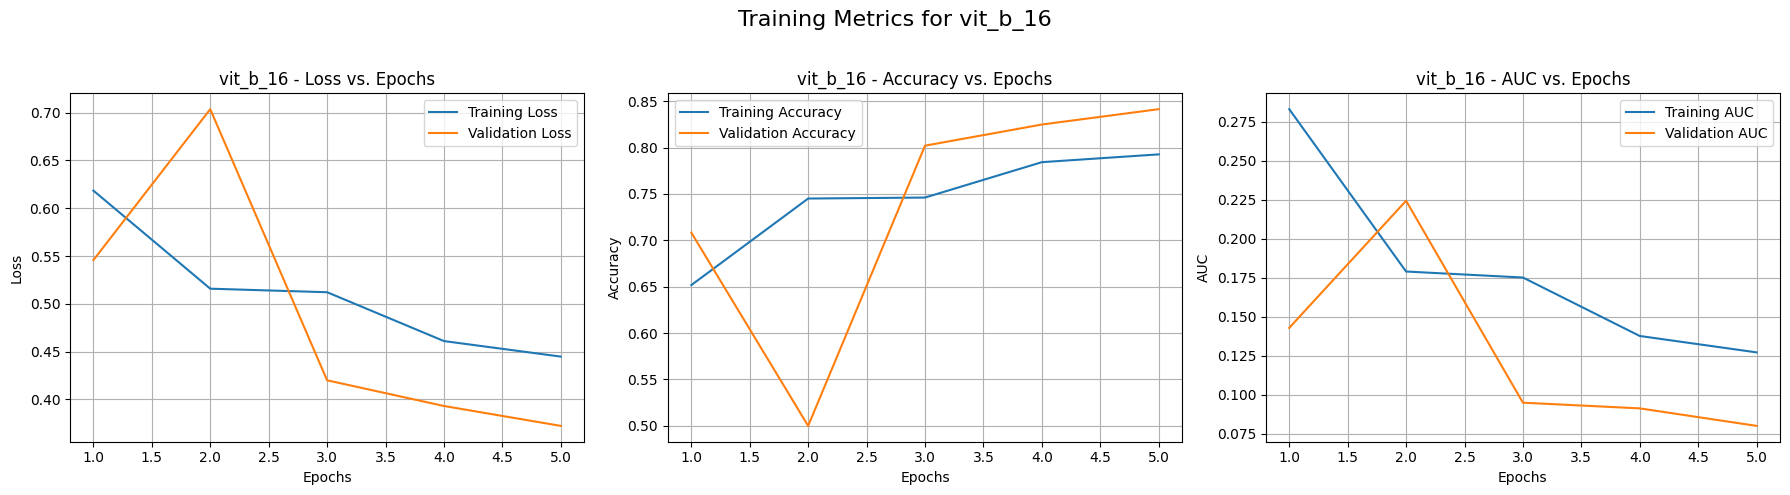

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub # Import kagglehub

# --- 0. Configuration Parameters ---
KAGGLE_DATASET_SLUG = 'birdy654/cifake-real-and-ai-generated-synthetic-images' # Kaggle Hub slug
MODEL_NAME = 'vit_b_16' # Changed to Vision Transformer (ViT-B/16)
NUM_CLASSES = 2  # REAL vs FAKE
BATCH_SIZE = 32 # Adjust based on GPU memory (ViT can be memory intensive)
NUM_EPOCHS = 5
LEARNING_RATE = 0.001 # ViTs can sometimes benefit from smaller LRs or different optimizers, but Adam is a good start
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Download Dataset using kagglehub ---
print(f"Downloading dataset {KAGGLE_DATASET_SLUG} using kagglehub...")
try:
    dataset_root_path = kagglehub.dataset_download(KAGGLE_DATASET_SLUG)
    print(f"Dataset downloaded to: {dataset_root_path}")
except Exception as e:
    print(f"Error downloading dataset via kagglehub: {e}")
    print("Please ensure you have kagglehub installed (pip install kagglehub) and Kaggle API configured.")
    exit()

train_data_path = os.path.join(dataset_root_path, 'train')

if not os.path.exists(train_data_path):
    print(f"Error: Training data path {train_data_path} does not exist after download.")
    print(f"Please check the structure of the downloaded dataset at {dataset_root_path}")
    exit()

# --- 2. Data Preprocessing and Loading ---
# ViT-B/16 pretrained on ImageNet expects 224x224 input images
INPUT_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Standard for 224 input
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Same as validation transforms
        transforms.Resize(256),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_train_dataset_info = datasets.ImageFolder(train_data_path)
class_names = full_train_dataset_info.classes
print(f"Classes: {class_names}")
POSITIVE_CLASS_FOR_AUC = 'FAKE' # Define which class is "positive" for AUC
if POSITIVE_CLASS_FOR_AUC not in class_names:
    print(f"Error: Positive class '{POSITIVE_CLASS_FOR_AUC}' for AUC not found in dataset classes: {class_names}")
    exit()
print(f"Using '{POSITIVE_CLASS_FOR_AUC}' as the positive class for AUC calculation.")
print(f"Total images in original training set: {len(full_train_dataset_info)}")

total_len = len(full_train_dataset_info)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

print(f"Splitting data: Train={train_len}, Validation={val_len}, Test={test_len}")

targets = [s[1] for s in full_train_dataset_info.samples]
indices = list(range(total_len))

train_indices, remaining_indices, _, _ = train_test_split(
    indices, targets, test_size=(val_len + test_len) / total_len, random_state=42, stratify=targets
)
remaining_targets = [targets[i] for i in remaining_indices]
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, remaining_targets, test_size=test_len / (val_len + test_len), random_state=42, stratify=remaining_targets
)

class SubsetWithCustomTransform(torch.utils.data.Dataset):
    def __init__(self, base_dataset_filepaths_labels, transform=None):
        self.filepaths_labels = base_dataset_filepaths_labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __getitem__(self, index):
        filepath, label = self.filepaths_labels[index]
        img = self.loader(filepath)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.filepaths_labels)

original_samples = full_train_dataset_info.samples
train_samples_list = [original_samples[i] for i in train_indices]
val_samples_list = [original_samples[i] for i in val_indices]
test_samples_list = [original_samples[i] for i in test_indices]

image_datasets = {
    'train': SubsetWithCustomTransform(train_samples_list, data_transforms['train']),
    'val': SubsetWithCustomTransform(val_samples_list, data_transforms['val']),
    'test': SubsetWithCustomTransform(test_samples_list, data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")

# --- 3. Build Vision Transformer (ViT-B/16) Model ---
def get_model(model_name_str, num_classes_val, pretrained=True):
    model_ft = None
    if model_name_str == 'vit_b_16':
        if pretrained:
            weights = models.ViT_B_16_Weights.IMAGENET1K_V1
            model_ft = models.vit_b_16(weights=weights)
        else:
            model_ft = models.vit_b_16(weights=None)

        # ViT's classification head is typically model.heads.head
        num_ftrs = model_ft.heads.head.in_features
        model_ft.heads.head = nn.Linear(num_ftrs, num_classes_val)
    else:
        raise ValueError(f"Model {model_name_str} not supported by this function")
    return model_ft

model = get_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Note: ViTs often benefit from specific learning rate schedules and optimizers like AdamW.
# For simplicity, we start with Adam.

# --- 4. Training and Evaluation Functions ---
def train_model_epoch(current_model, dataloader, loss_criterion, opt, current_device):
    current_model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    for inputs, labels in dataloader:
        inputs = inputs.to(current_device)
        labels = labels.to(current_device)

        opt.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = current_model(inputs) # ViT returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)
            loss.backward()
            opt.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds_classes == labels.data)

        all_labels_list.extend(labels.cpu().numpy())
        positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
        probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().detach().numpy()
        all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5

    return epoch_loss, epoch_acc.item(), epoch_auc

def evaluate_model(current_model, dataloader, loss_criterion, current_device, phase='val'):
    current_model.eval() # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(current_device)
            labels = labels.to(current_device)

            outputs = current_model(inputs) # ViT returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_classes == labels.data)

            all_labels_list.extend(labels.cpu().numpy())
            positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
            probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().numpy()
            all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5

    return epoch_loss, epoch_acc.item(), epoch_auc

# --- 5. Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

print(f"\nStarting Training for {MODEL_NAME}...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    train_loss, train_acc, train_auc = train_model_epoch(model, dataloaders['train'], criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f}")

    val_loss, val_acc, val_auc = evaluate_model(model, dataloaders['val'], criterion, DEVICE, phase='val')
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time // 60:.0f}m {training_time % 60:.0f}s")

# --- 6. Evaluate on Test Set ---
print(f"\nEvaluating {MODEL_NAME} on Test Set...")
test_loss, test_acc, test_auc = evaluate_model(model, dataloaders['test'], criterion, DEVICE, phase='test')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- 7. Plot Results ---
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} - Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title(f'{MODEL_NAME} - Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title(f'{MODEL_NAME} - AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(f"training_metrics_{MODEL_NAME}_plot.png")
print(f"\nPlot saved as training_metrics_{MODEL_NAME}_plot.png")
plt.show()

# (Optional) Save the trained model
# model_save_path = f'{MODEL_NAME}_cifake_epochs{NUM_EPOCHS}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

Using device: cuda
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']
Using 'FAKE' as the positive class for AUC calculation.
Total images in original training set: 100000
Splitting data: Train=60000, Validation=20000, Test=20000
Train dataset size: 60000
Validation dataset size: 20000
Test dataset size: 20000


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 201MB/s]



Starting Training for vit_b_16...
Epoch 1/5
----------
Train Loss: 0.6254 Acc: 0.6478 AUC: 0.7076
Val Loss: 0.5382 Acc: 0.7291 AUC: 0.8243
Epoch 2/5
----------
Train Loss: 0.5373 Acc: 0.7297 AUC: 0.8036
Val Loss: 0.5164 Acc: 0.7361 AUC: 0.8779
Epoch 3/5
----------
Train Loss: 0.5098 Acc: 0.7480 AUC: 0.8259
Val Loss: 0.5538 Acc: 0.7264 AUC: 0.8789
Epoch 4/5
----------
Train Loss: 0.4830 Acc: 0.7676 AUC: 0.8467
Val Loss: 0.4009 Acc: 0.8209 AUC: 0.9113
Epoch 5/5
----------
Train Loss: 0.4586 Acc: 0.7851 AUC: 0.8636
Val Loss: 0.3775 Acc: 0.8377 AUC: 0.9200

Training complete in 196m 16s

Evaluating vit_b_16 on Test Set...
Test Loss: 0.3768
Test Accuracy: 0.8355
Test AUC: 0.9204

Plot saved as training_metrics_vit_b_16_plot.png


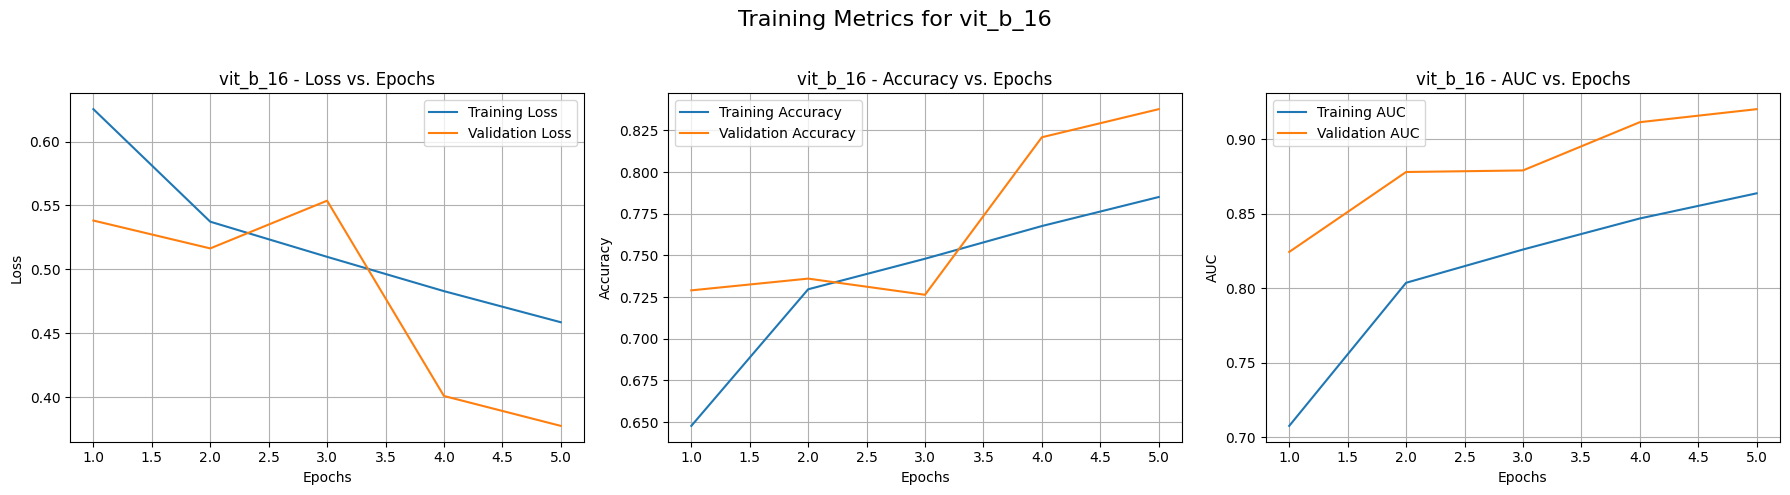

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub # Import kagglehub

# --- 0. Configuration Parameters ---
KAGGLE_DATASET_SLUG = 'birdy654/cifake-real-and-ai-generated-synthetic-images' # Kaggle Hub slug
MODEL_NAME = 'vit_b_16' # Changed to Vision Transformer (ViT-B/16)
NUM_CLASSES = 2  # REAL vs FAKE
BATCH_SIZE = 32 # Adjust based on GPU memory (ViT can be memory intensive)
NUM_EPOCHS = 5
LEARNING_RATE = 0.001 # ViTs can sometimes benefit from smaller LRs or different optimizers, but Adam is a good start
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Download Dataset using kagglehub ---
print(f"Downloading dataset {KAGGLE_DATASET_SLUG} using kagglehub...")
try:
    dataset_root_path = kagglehub.dataset_download(KAGGLE_DATASET_SLUG)
    print(f"Dataset downloaded to: {dataset_root_path}")
except Exception as e:
    print(f"Error downloading dataset via kagglehub: {e}")
    print("Please ensure you have kagglehub installed (pip install kagglehub) and Kaggle API configured.")
    exit()

train_data_path = os.path.join(dataset_root_path, 'train')

if not os.path.exists(train_data_path):
    print(f"Error: Training data path {train_data_path} does not exist after download.")
    print(f"Please check the structure of the downloaded dataset at {dataset_root_path}")
    exit()

# --- 2. Data Preprocessing and Loading ---
# ViT-B/16 pretrained on ImageNet expects 224x224 input images
INPUT_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Standard for 224 input
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Same as validation transforms
        transforms.Resize(256),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_train_dataset_info = datasets.ImageFolder(train_data_path)
class_names = full_train_dataset_info.classes
print(f"Classes: {class_names}")
POSITIVE_CLASS_FOR_AUC = 'FAKE' # Define which class is "positive" for AUC
if POSITIVE_CLASS_FOR_AUC not in class_names:
    print(f"Error: Positive class '{POSITIVE_CLASS_FOR_AUC}' for AUC not found in dataset classes: {class_names}")
    exit()
print(f"Using '{POSITIVE_CLASS_FOR_AUC}' as the positive class for AUC calculation.")
print(f"Total images in original training set: {len(full_train_dataset_info)}")

total_len = len(full_train_dataset_info)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

print(f"Splitting data: Train={train_len}, Validation={val_len}, Test={test_len}")

targets = [s[1] for s in full_train_dataset_info.samples]
indices = list(range(total_len))

train_indices, remaining_indices, _, _ = train_test_split(
    indices, targets, test_size=(val_len + test_len) / total_len, random_state=42, stratify=targets
)
remaining_targets = [targets[i] for i in remaining_indices]
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, remaining_targets, test_size=test_len / (val_len + test_len), random_state=42, stratify=remaining_targets
)

class SubsetWithCustomTransform(torch.utils.data.Dataset):
    def __init__(self, base_dataset_filepaths_labels, transform=None):
        self.filepaths_labels = base_dataset_filepaths_labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __getitem__(self, index):
        filepath, label = self.filepaths_labels[index]
        img = self.loader(filepath)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.filepaths_labels)

original_samples = full_train_dataset_info.samples
train_samples_list = [original_samples[i] for i in train_indices]
val_samples_list = [original_samples[i] for i in val_indices]
test_samples_list = [original_samples[i] for i in test_indices]

image_datasets = {
    'train': SubsetWithCustomTransform(train_samples_list, data_transforms['train']),
    'val': SubsetWithCustomTransform(val_samples_list, data_transforms['val']),
    'test': SubsetWithCustomTransform(test_samples_list, data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")

# --- 3. Build Vision Transformer (ViT-B/16) Model ---
def get_model(model_name_str, num_classes_val, pretrained=True):
    model_ft = None
    if model_name_str == 'vit_b_16':
        if pretrained:
            weights = models.ViT_B_16_Weights.IMAGENET1K_V1
            model_ft = models.vit_b_16(weights=weights)
        else:
            model_ft = models.vit_b_16(weights=None)

        # ViT's classification head is typically model.heads.head
        num_ftrs = model_ft.heads.head.in_features
        model_ft.heads.head = nn.Linear(num_ftrs, num_classes_val)
    else:
        raise ValueError(f"Model {model_name_str} not supported by this function")
    return model_ft

model = get_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Note: ViTs often benefit from specific learning rate schedules and optimizers like AdamW.
# For simplicity, we start with Adam.

# --- 4. Training and Evaluation Functions ---
def train_model_epoch(current_model, dataloader, loss_criterion, opt, current_device):
    current_model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []

    for inputs, labels in dataloader:
        inputs = inputs.to(current_device)
        labels = labels.to(current_device)

        opt.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = current_model(inputs) # ViT returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)
            loss.backward()
            opt.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds_classes == labels.data)

        all_labels_list.extend(labels.cpu().numpy())
        positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
        label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}
        probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().detach().numpy()
        all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

def evaluate_model(current_model, dataloader, loss_criterion, current_device, phase='val'):
    current_model.eval() # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_labels_list = []
    all_preds_probs_list = []
    positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
    label_to_auc_binary = {i: 1 if i == positive_class_idx else 0 for i in range(len(class_names))}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(current_device)
            labels = labels.to(current_device)

            outputs = current_model(inputs) # ViT returns a single output tensor
            loss = loss_criterion(outputs, labels)
            _, preds_classes = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_classes == labels.data)

            all_labels_list.extend(labels.cpu().numpy())
            positive_class_idx = class_names.index(POSITIVE_CLASS_FOR_AUC)
            probs = torch.softmax(outputs, dim=1)[:, positive_class_idx].cpu().numpy()
            all_preds_probs_list.extend(probs)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    #epoch_auc = roc_auc_score(all_labels_list, all_preds_probs_list) if len(np.unique(all_labels_list)) > 1 else 0.5
    adjusted_labels = [label_to_auc_binary[y] for y in all_labels_list]
    epoch_auc = roc_auc_score(adjusted_labels, all_preds_probs_list)

    return epoch_loss, epoch_acc.item(), epoch_auc

# --- 5. Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

print(f"\nStarting Training for {MODEL_NAME}...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    train_loss, train_acc, train_auc = train_model_epoch(model, dataloaders['train'], criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f}")

    val_loss, val_acc, val_auc = evaluate_model(model, dataloaders['val'], criterion, DEVICE, phase='val')
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time // 60:.0f}m {training_time % 60:.0f}s")

# --- 6. Evaluate on Test Set ---
print(f"\nEvaluating {MODEL_NAME} on Test Set...")
test_loss, test_acc, test_auc = evaluate_model(model, dataloaders['test'], criterion, DEVICE, phase='test')
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- 7. Plot Results ---
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} - Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title(f'{MODEL_NAME} - Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['train_auc'], label='Training AUC')
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.title(f'{MODEL_NAME} - AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.savefig(f"training_metrics_{MODEL_NAME}_plot.png")
print(f"\nPlot saved as training_metrics_{MODEL_NAME}_plot.png")
plt.show()

# (Optional) Save the trained model
# model_save_path = f'{MODEL_NAME}_cifake_epochs{NUM_EPOCHS}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_transformer.csv', index=False)
print("Training history saved to training_history_transformer.csv")

Training history saved to training_history_transformer.csv
